# Importing Libraries

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.4 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import backend as K
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing Dataset

In [3]:
df = pd.read_csv('parkinsons_updrs.csv')

In [4]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

In [6]:
df.isnull().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

No null values found in the dataset

In [7]:
df.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Here we can see a weird discrepancy in the data. The min value of "test_time" is negative. 

From the UCI ML Repository, the description of "test_time" is as follows: "Time since recruitment into the trial. The integer part is the number of days since recruitment."

How can that be negative for a patient?

In [8]:
df[df['test_time'] < 0].count()

subject#         12
age              12
sex              12
test_time        12
motor_UPDRS      12
total_UPDRS      12
Jitter(%)        12
Jitter(Abs)      12
Jitter:RAP       12
Jitter:PPQ5      12
Jitter:DDP       12
Shimmer          12
Shimmer(dB)      12
Shimmer:APQ3     12
Shimmer:APQ5     12
Shimmer:APQ11    12
Shimmer:DDA      12
NHR              12
HNR              12
RPDE             12
DFA              12
PPE              12
dtype: int64

We have 12 such entries that have a negative "test_time". It is better to drop these entries to avoid confusion for the models.

In [9]:
df = df[df['test_time'] > 0]

## Correlation Matrix

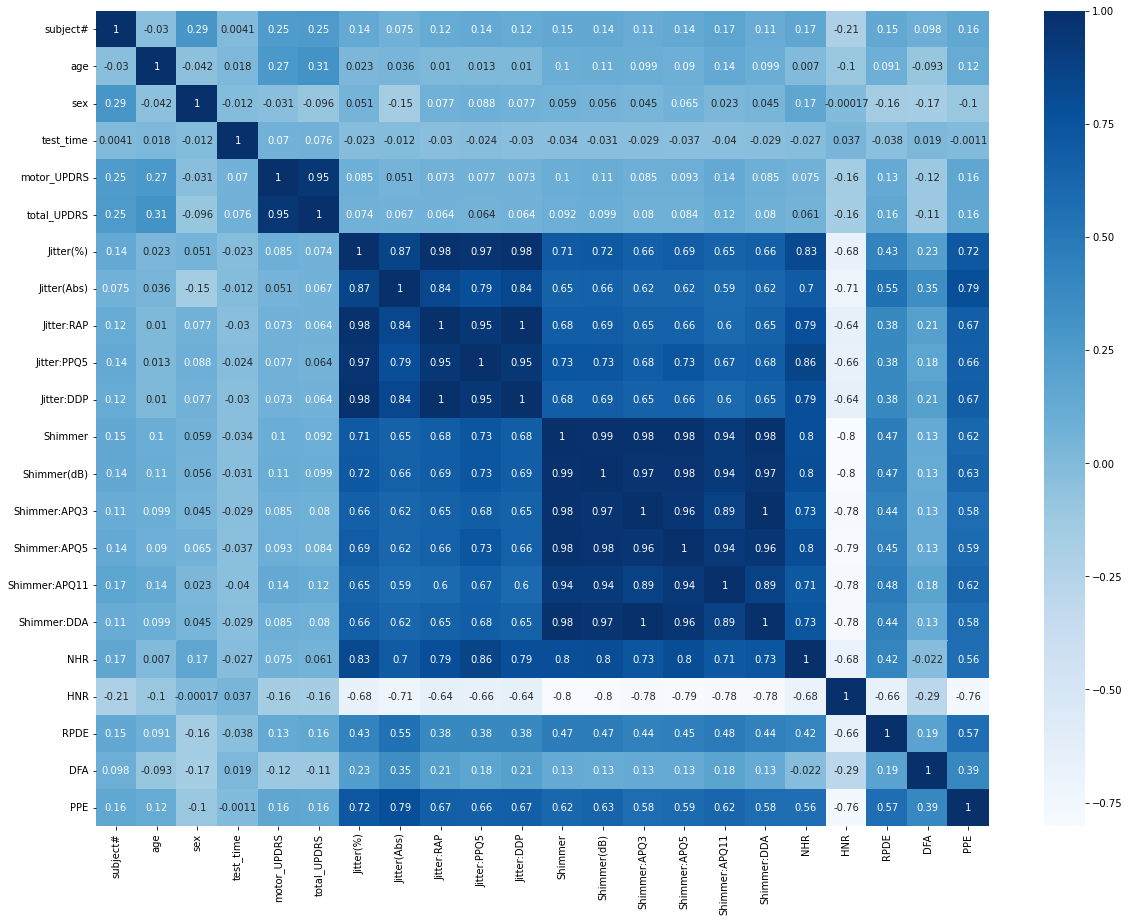

In [10]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap='Blues')

As we can see, the data is highly correlated. Let us use Principal Component Analysis to narrow down the correlated features.

## PCA

In [11]:
data = df.copy()

Let us drop "subject#" from the dataset entirely as it not useful for our model. 

Let us also seperate the target variables before applying PCA.

In [12]:
data.drop(['subject#'], axis=1, inplace=True)

In [13]:
y1 = data['motor_UPDRS']
y2 = data['total_UPDRS']
data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

## Splitting the data into Training and Test Set

In [14]:
x1_train, x1_test, y1_train, y1_test = train_test_split(data, y1, test_size=0.2, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(data, y2, test_size=0.2, random_state=42)

I will use x1_train to perform PCA tests.

In [15]:
pca = PCA(n_components=14)
principal_components = pca.fit_transform(data)

In [16]:
pca_df = pd.DataFrame(principal_components, columns=['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10','PCA11','PCA12','PCA13','PCA14'])

In [17]:
pca_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14
0,-87.395804,-7.420439,-0.726184,-0.305428,-0.061443,-0.145538,-0.117522,-0.039417,-0.005717,0.004253,-0.005202,0.007683,-0.000184,0.000895
1,-80.356512,-7.029604,-6.230253,-0.300305,0.123614,-0.029321,-0.056080,-0.010225,0.015743,0.000700,0.001452,0.001396,-0.000623,0.000759
2,-73.353852,-7.286398,-2.084574,-0.306433,-0.051730,-0.065026,-0.080630,-0.084761,-0.003402,-0.005916,-0.003816,0.000107,-0.000292,0.000044
3,-67.383779,-7.176695,-3.449752,-0.303573,0.151028,0.019233,0.044212,-0.143779,-0.033837,-0.014053,-0.013288,-0.008359,-0.001464,-0.003801
4,-59.383841,-7.040801,-5.108805,-0.302410,0.073341,0.003149,-0.031279,-0.068282,-0.002099,-0.006452,0.001422,-0.001590,-0.000216,0.000102


Plotting a Scree plot to perform the Elbow method to find the ideal components of PCA

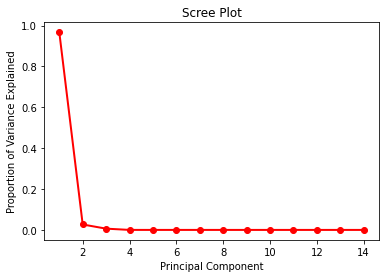

In [18]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [19]:
print(pca.explained_variance_)

[2.84316873e+03 7.81730907e+01 1.81791690e+01 2.17453979e-01
 2.05138259e-02 5.55632337e-03 5.02483651e-03 2.68092818e-03
 1.00518116e-03 1.03934678e-04 4.52955553e-05 3.22145711e-05
 6.80769578e-06 3.37466484e-06]


Hence we decide to keep 3 Principal Components as from the 4th value onwards, the Eigen Values are less than 1.

The reason we seperated the data into training and test set so early is due avoid information leakage and overfitting of our model. 

The model should never have seen the test data to evaluate it's performance accurately.

In [20]:
pca1 = PCA(n_components=3, random_state=42)
pca2 = PCA(n_components=3, random_state=42)
x1_train = pca1.fit_transform(x1_train)
x1_test = pca1.transform(x1_test)

x2_train = pca2.fit_transform(x2_train)
x2_test = pca2.transform(x2_test)

Our data is ready to be fitted into Regression Models.

## Function for Evaluating Model Performance

In [21]:
def score(y_pred,y_test):
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)*100
    print("Mean Absolute Error: ", mae)
    print("Mean Squared Error: ", mse)
    print("R2 score: ", r2,)
    return (mae, mse, r2)

# Models

## Y1 Variabale: motor_UPDRS

### Decision Tree Regression

In [22]:
dt_reg1 = DecisionTreeRegressor()
dt_reg1.fit(x1_train, y1_train)
y_dt_pred1 = dt_reg1.predict(x1_test)

In [23]:
dt_mae1, dt_mse1, dt_r21 = score(y1_test, y_dt_pred1)

Mean Absolute Error:  1.5180572904234158
Mean Squared Error:  18.74851962349491
R2 score:  70.70537827711192


### Random Forrest Regression

In [24]:
rf_reg1 = RandomForestRegressor()
rf_reg1.fit(x1_train, y1_train)
y_rf_pred1 = rf_reg1.predict(x1_test)

In [25]:
rf_mae1, rf_mse1, rf_r21 = score(y1_test, y_rf_pred1)

Mean Absolute Error:  2.093566742504836
Mean Squared Error:  15.278154239127852
R2 score:  70.56090516058853


### XGBoost Regression

In [26]:
xgb_reg1 = XGBRegressor(objective='reg:squarederror')
xgb_reg1.fit(x1_train, y1_train)
y_xgb_pred1 = xgb_reg1.predict(x1_test)

In [27]:
xgb_mae1, xgb_mse1, xgb_r21 = score(y1_test, y_xgb_pred1)

Mean Absolute Error:  3.786191707707996
Mean Squared Error:  24.116033475253715
R2 score:  24.59127687143289


## Comparing Model1 Performance

In [28]:
model_mae1 = [dt_mae1, rf_mae1, xgb_mae1]
model_mse1 = [dt_mse1, rf_mse1, xgb_mse1]
model_r21 = [dt_r21, rf_r21, xgb_r21]
models=["Decision Tree", "Random Forrest", "XGBoost"]

Text(0.5, 1.0, 'Comparing Model1 MAE(Test Set)')

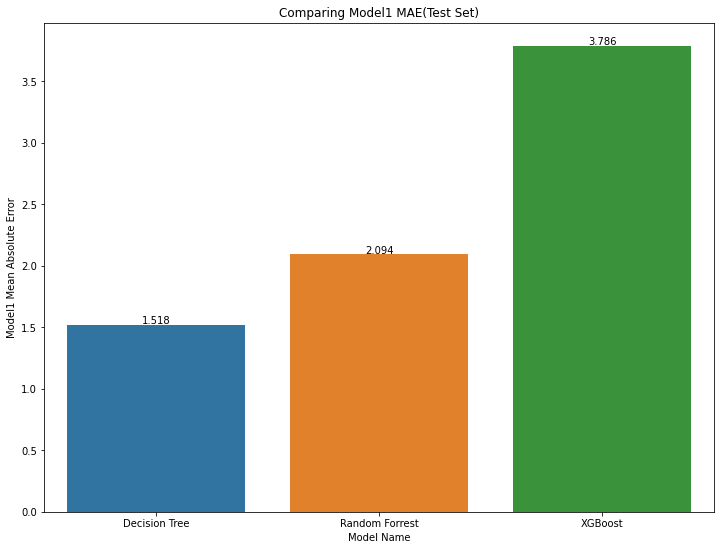

In [29]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mae1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 MSE(Test Set)')

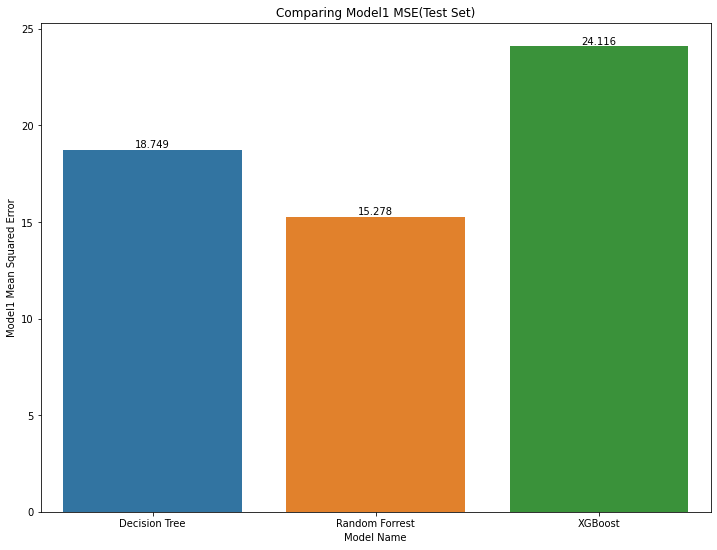

In [30]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_mse1)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model1 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model1 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model1 R2 Score(Test Set)')

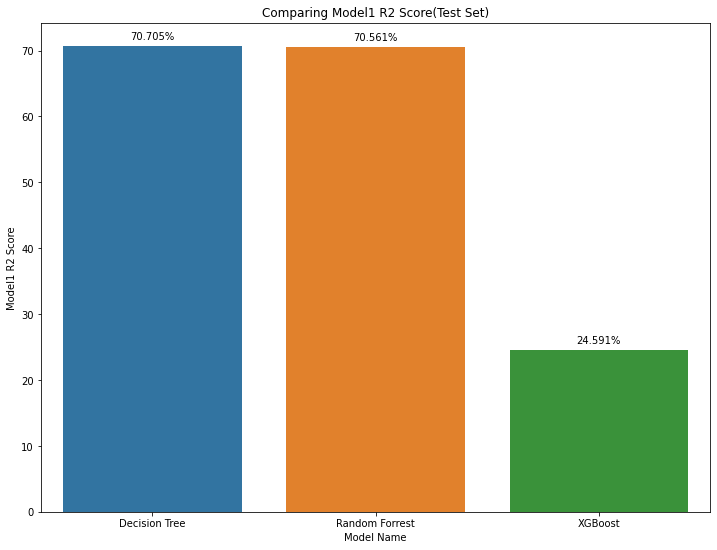

In [31]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models, y=model_r21)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model1 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model1 R2 Score(Test Set)')

### Performing Cross Validation for our models.

#### R2 Score

In [32]:
dt_cv1 = cross_val_score(dt_reg1,x1_train, y1_train, cv=10, scoring='r2')
rf_cv1 = cross_val_score(rf_reg1,x1_train, y1_train, cv=10, scoring='r2')
xgb_cv1 = cross_val_score(xgb_reg1,x1_train, y1_train, cv=10, scoring='r2')

In [33]:
print("Cross Validation Score for Decision Tree Regression is: {:1.3f} +- {:1.3f}".format(dt_cv1.mean()*100, dt_cv1.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv1.mean()*100, rf_cv1.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv1.mean()*100, xgb_cv1.std()*100))

Cross Validation Score for Decision Tree Regression is: 64.980 +- 6.698
Cross Validation Score for Random Forrest Regression is: 76.639 +- 2.378
Cross Validation Score for XGBoost Model is: 63.458 +- 1.499


#### Thus Random Forrest Regression is the best model for Y1 Variable(motor_UPDRS) with a **MAE of 2.09 and R2 score of 77%**

## Y2 Variable: total_UPDRS

The Correlation Matrix gave us an interesting insight. "motor_UPDRS" and "total_UPDRS" are highly correlated(0.95).

In our current dataset, we already have the recorded data of "motor_UPDRS". But for future predictions, that might not be the case.

Hence we can use feature engineering to get a new highly correlated feature using our Model 1 for the "total_UPDRS" prediction.

We will use Random Forrest predictions as the new feature for our Model 2 as it was the best performing model.

### Adding the "motor_UPDRS" values predicted by our Model 1 to the second training and test set.

In [34]:
motor_train = rf_reg1.predict(x1_train)
motor_test = rf_reg1.predict(x1_test)

In [35]:
x2_train = pd.DataFrame(x2_train, columns = ['PCA1', 'PCA2', 'PCA3'])

In [36]:
x2_test = pd.DataFrame(x2_test, columns = ['PCA1', 'PCA2', 'PCA3'])

In [37]:
x2_train['motor_UPDRS'] = motor_train

In [38]:
x2_test['motor_UPDRS'] = motor_test

### Linear Regression

In [39]:
lin_reg2 = LinearRegression()
lin_reg2.fit(x2_train, y2_train)
y_lin_pred2 = lin_reg2.predict(x2_test)

In [40]:
lin_mae2, lin_mse2, lin_r22 = score(y2_test,y_lin_pred2)

Mean Absolute Error:  4.0207875545643414
Mean Squared Error:  30.51821687340556
R2 score:  66.65944760071123


### Polynomial Regression

In [41]:
poly2 = PolynomialFeatures(degree=3)
x2_poly = poly2.fit_transform(x2_train)

In [42]:
poly_reg2 = LinearRegression()
poly_reg2.fit(x2_poly, y2_train)
y_poly_pred2 = poly_reg2.predict(poly2.transform(x2_test))

In [43]:
poly_mae2, poly_mse2, poly_r22 = score(y2_test, y_poly_pred2)

Mean Absolute Error:  3.810920840744952
Mean Squared Error:  28.977602635069577
R2 score:  69.01937979073266


### Support Vector Machines

In [44]:
svr_reg2 = SVR()
svr_reg2.fit(x2_train, y2_train)
y_svr_pred2 = svr_reg2.predict(x2_test)

In [45]:
svr_mae2, svr_mse2, svr_r22 = score(y2_test, y_svr_pred2)

Mean Absolute Error:  3.9796129342788906
Mean Squared Error:  30.636201678004458
R2 score:  61.34218065733374


### Decision Tree Regression

In [46]:
dt_reg2 = DecisionTreeRegressor()
dt_reg2.fit(x2_train, y2_train)
y_dt_pred2 = dt_reg2.predict(x2_test)

In [47]:
dt_mae2, dt_mse2, dt_r22 = score(y2_test, y_dt_pred2)

Mean Absolute Error:  2.3231729127593064
Mean Squared Error:  28.745536085755173
R2 score:  73.24040508093962


### Random Forrest Regression

In [48]:
rf_reg2 = RandomForestRegressor()
rf_reg2.fit(x2_train, y2_train)
y_rf_pred2 = rf_reg2.predict(x2_test)

In [49]:
rf_mae2, rf_mse2, rf_r22 = score(y2_test, y_rf_pred2)

Mean Absolute Error:  2.2991513932969956
Mean Squared Error:  24.771336298981097
R2 score:  75.63307871126405


### XGBoost Regression

In [50]:
xgb_reg2 = XGBRegressor(objective='reg:squarederror')
xgb_reg2.fit(x2_train, y2_train)
y_xgb_pred2 = xgb_reg2.predict(x2_test)

In [51]:
xgb_mae2, xgb_mse2, xgb_r22 = score(y2_test, y_xgb_pred2)

Mean Absolute Error:  3.093332010352093
Mean Squared Error:  23.377414195003023
R2 score:  75.03573371446959


## Comparing Model2 Performance

In [52]:
model_mae2 = [lin_mae2,poly_mae2, svr_mae2, dt_mae2, rf_mae2, xgb_mae2]
model_mse2 = [lin_mse2,poly_mse2, svr_mse2, dt_mse2, rf_mse2, xgb_mse2]
model_r22 = [lin_r22,poly_r22, svr_r22, dt_r22, rf_r22, xgb_r22]
models2 = ["Linear Regression", "Polynomial Regression", "Support Vector Machines","Decision Tree", "Random Forrest", "XGBoost"]

Text(0.5, 1.0, 'Comparing Model2 MAE(Test Set)')

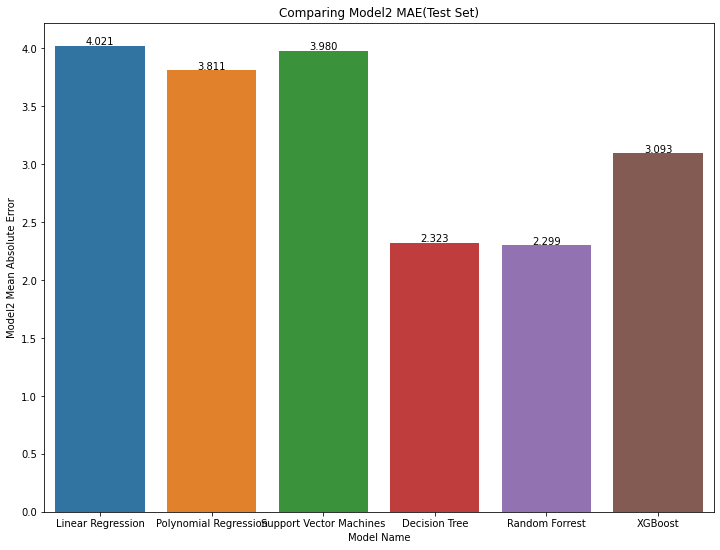

In [53]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_mae2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.01,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Absolute Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MAE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 MSE(Test Set)')

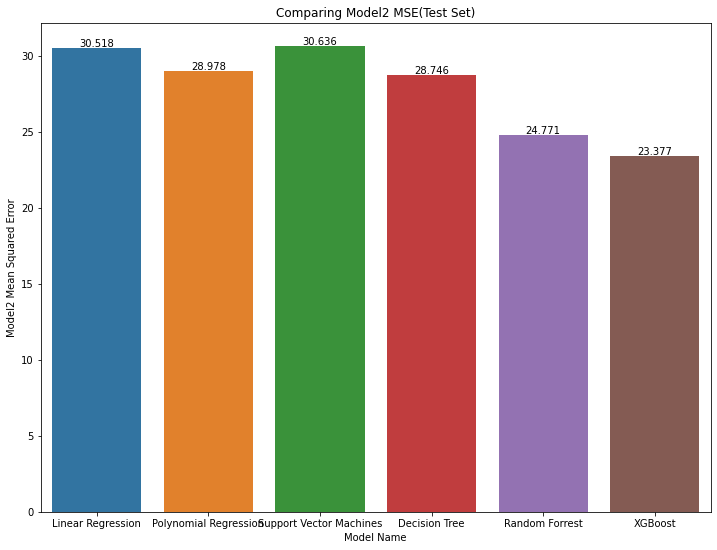

In [54]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_mse2)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height+0.1,
          '{:1.3f}'.format(height),
          ha='center')
  
plt.ylabel('Model2 Mean Squared Error')
plt.xlabel('Model Name')
plt.title('Comparing Model2 MSE(Test Set)')

Text(0.5, 1.0, 'Comparing Model2 R2 Score(Test Set)')

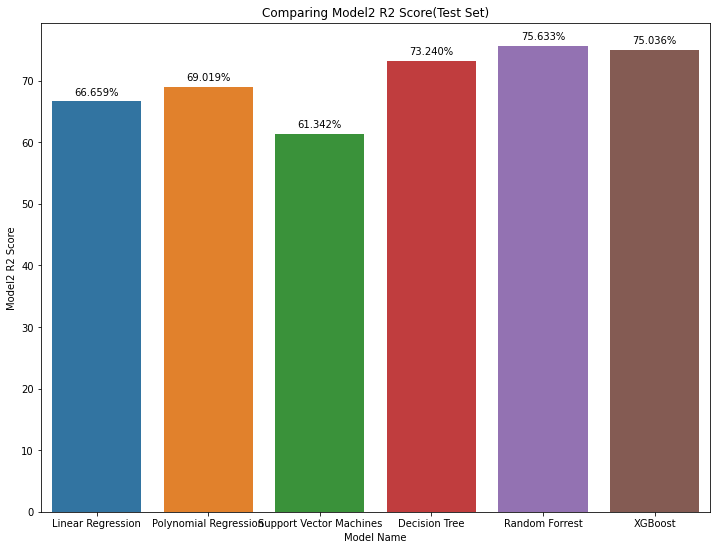

In [55]:
plt.figure(figsize=(12,9))
ax = sns.barplot(x=models2, y=model_r22)
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 1,
          '{:1.3f}%'.format(height),
          ha='center')
  
plt.ylabel('Model2 R2 Score')
plt.xlabel('Model Name')
plt.title('Comparing Model2 R2 Score(Test Set)')

### Performing Cross Validation for our 3 best performing models

In [56]:
dt_cv2 = cross_val_score(dt_reg2,x2_train, y2_train, cv=10, scoring='r2')
rf_cv2 = cross_val_score(rf_reg2,x2_train, y2_train, cv=10, scoring='r2')
xgb_cv2 = cross_val_score(xgb_reg2,x2_train, y2_train, cv=10, scoring='r2')

In [57]:
print("Cross Validation Score for Decision Tree Regression is: {:1.3f} +- {:1.3f}".format(dt_cv2.mean()*100, dt_cv2.std()*100))
print("Cross Validation Score for Random Forrest Regression is: {:1.3f} +- {:1.3f}".format(rf_cv2.mean()*100, rf_cv2.std()*100))
print("Cross Validation Score for XGBoost Model is: {:1.3f} +- {:1.3f}".format(xgb_cv2.mean()*100, xgb_cv2.std()*100))

Cross Validation Score for Decision Tree Regression is: 97.343 +- 0.389
Cross Validation Score for Random Forrest Regression is: 98.644 +- 0.225
Cross Validation Score for XGBoost Model is: 95.463 +- 0.404


#### Thus Random Forrest Regressionis is the best model for Y2 Variable(total_UPDRS) with a **MAE of 2.3 and R2 score of 98.64%**

# Deep Learning Approach

In [58]:
df.drop(['subject#'], axis=1, inplace=True)

In [59]:
df.head()

,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [60]:
y = df.iloc[:, [3,4]].values

In [61]:
df.drop(['motor_UPDRS', 'total_UPDRS'], axis=1, inplace=True)

In [62]:
x = df.values

### Splitting data into Training and Test set

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Standardizing so that the Standard deviation is 1 and mean is 0 for all features.

In [64]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

### Artificial Neural Network

In [65]:
ann1 = Sequential([
                   Dense(units=128, activation='relu'),
                   Dropout(0.2),
                   Dense(units=64, activation='relu'),
                   Dropout(0.2),
                   Dense(units=32, activation='relu'),
                   Dropout(0.2),
                   Dense(units=16, activation='relu'),
                   Dense(units=2)
])

In [66]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [67]:
ann1.compile(optimizer='adam', loss="mean_absolute_error", metrics=[r2, 'mae'])

In [68]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_r2') > 0.99):
            print("\nReached 99% R2 score so cancelling training!")
            self.model.stop_training = True
        
callback = myCallback()

In [69]:
r1 = ann1.fit(x_train, y_train,
              validation_data=(x_test, y_test), batch_size=64, epochs=700, callbacks=[callback])

Epoch 1/700
74/74 [==============================] - 4s 8ms/step - loss: 19.0767 - r2: -3.7820 - mae: 19.0767 - val_loss: 10.2665 - val_r2: -0.7058 - val_mae: 10.2665
Epoch 2/700
74/74 [==============================] - 0s 5ms/step - loss: 8.9770 - r2: -0.2795 - mae: 8.9770 - val_loss: 7.9275 - val_r2: 0.0201 - val_mae: 7.9275
Epoch 3/700
74/74 [==============================] - 0s 4ms/step - loss: 8.0770 - r2: -0.0487 - mae: 8.0770 - val_loss: 7.3739 - val_r2: 0.1460 - val_mae: 7.3739
Epoch 4/700
74/74 [==============================] - 0s 5ms/step - loss: 7.6669 - r2: 0.0585 - mae: 7.6669 - val_loss: 7.1485 - val_r2: 0.1916 - val_mae: 7.1485
Epoch 5/700
74/74 [==============================] - 0s 4ms/step - loss: 7.5156 - r2: 0.1005 - mae: 7.5156 - val_loss: 6.9273 - val_r2: 0.2273 - val_mae: 6.9273
Epoch 6/700
74/74 [==============================] - 0s 5ms/step - loss: 7.3277 - r2: 0.1266 - mae: 7.3277 - val_loss: 6.7504 - val_r2: 0.2736 - val_mae: 6.7504
Epoch 7/700
74/74 [=======

In [70]:
ann1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

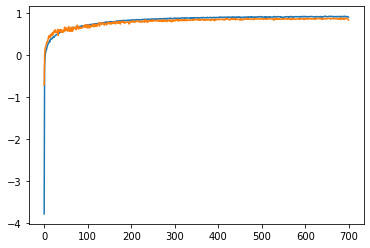

In [71]:
plt.plot(r1.history['r2'], label='R2')
plt.plot(r1.history['val_r2'], label='Val_R2')

In [72]:
ann_score = ann1.evaluate(x_test, y_test)

37/37 [==============================] - 0s 2ms/step - loss: 2.4399 - r2: 0.8382 - mae: 2.4399


In [73]:
ann_r2 = ann_score[1]*100

Our Neural Network gave us a **MAE of 2.44** and **R2 score of 84%**

Text(0.5, 1.0, 'Comparing Neural Network MAE to Random Forrest MAE')

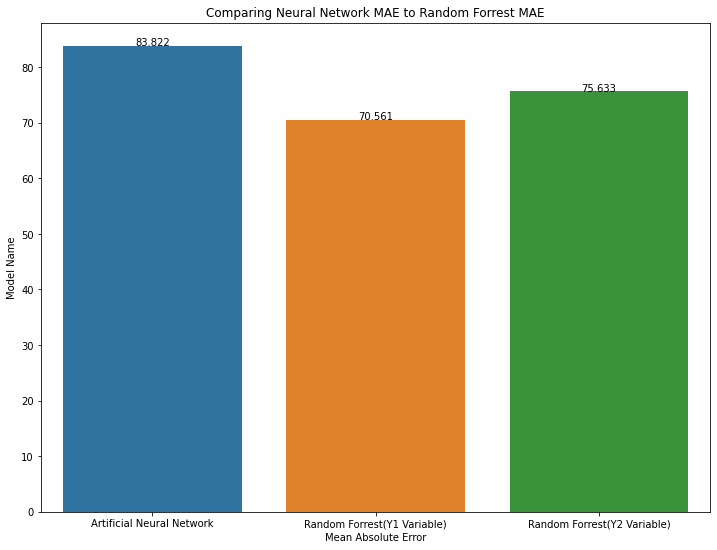

In [74]:
plt.figure(figsize=(12,9))
ax = sns.barplot(y=[ann_r2, rf_r21, rf_r22], x=['Artificial Neural Network', 'Random Forrest(Y1 Variable)', 'Random Forrest(Y2 Variable)'])
for p in ax.patches:
  height = p.get_height()
  ax.text(p.get_x() + p.get_width()/2.,
          height + 0.01,
          '{:1.3f}'.format(height),
          ha='center')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model Name')
plt.title('Comparing Neural Network MAE to Random Forrest MAE')